Artificial Neural Networks
================

------
**Deep Learning for Computer Vision**<br>
(c) Research Group CAMMA, University of Strasbourg<br>
Website: http://camma.u-strasbg.fr/
-----

### About this notebook

- **Objectives**: 
  - Train and test simple ANNs
  - Experiment with underfitting / overfitting
  - Perform experiments on Spiral3 and MNIST
  

- **Instructions**:
  - To make the best use of this notebook, read the provided instructions and code, fill in the *#TODO* blocks, and run the code.
  - Load MNIST dataset from https://seafile.unistra.fr/f/11b3075bb2df41cf8db2/?dl=1
  

### Warm-up

Go to the [Tensorflow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.90143&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&percTrainData_hide=true&discretize_hide=true&noise_hide=true&problem_hide=true)

1. Study the complexity of each of the 4 proposed datasets for classification

2. Experiment with the network structure and training parameters to classify each dataset using only the point coordinates as input features 

3. Study underfitting and overfitting behaviors by acting on network capacity and regularization parameter

4. If non-linear features are used as input, how much can you simplify the network structure and training process? 

### Neural Networks for Classification of Spiral3 Toy Dataset

Import libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

Create and visualize the dataset:

In [2]:
def toy_spiral3(N=200, K=3, D=2):
  np.random.seed(0)
  #N: number of points per class
  #D: dimensionality
  #K: number of classes
  X = np.zeros((N*K,D))
  y = np.zeros(N*K, dtype='uint8')
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = 5 + np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.3 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  return X,y

In [3]:
def toy_plot(X,y):  
  fig = plt.figure()
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.xlim([-1.5,1.5])
  plt.ylim([-1.5,1.5])

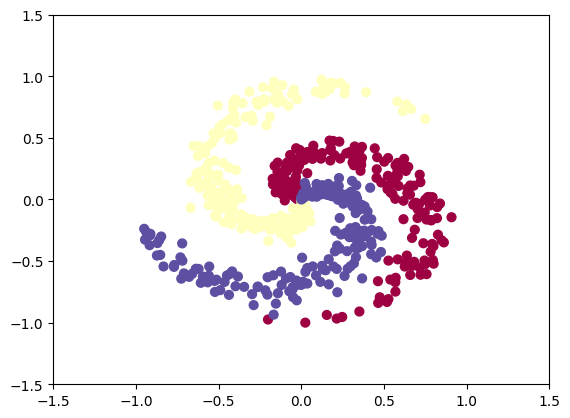

In [4]:
np.random.seed(999) #For reproducibility
[X,y] = toy_spiral3(200)
toy_plot(X,y)

**Code for training and inference of a 2-layer neural network**

Identify the difference compared to the Softmax code from the previous notebook

In [7]:
class NN2LClassifier:

  def __init__(self, num_hidden=100, nclasses=3, ndims=2):
    self.nclasses = nclasses
    self.ndims = ndims
    self.h = num_hidden # size of hidden layer
    self.W1 = None
    self.b1 = None
    self.W2 = None
    self.b2 = None

  # Train the classifier's parameters
  def train(self, X, y, learning_rate=1e-0, reg_weight=1e-3, num_iters=10000, verbose=True):
    #Hyperparameters
    #learning_rate: gradient descent step size
    #reg_weight: regularization   
    N = X.shape[0] #number of data points
  
    # initialize parameters randomly
    self.W1 = 0.01 *np.random.randn(self.ndims,self.h) #NOTE: much faster if you remove 0.01 here
    self.b1 = np.zeros((1,self.h))
    self.W2 = 0.01 *np.random.randn(self.h,self.nclasses)
    self.b2 = np.zeros((1,self.nclasses))

    #Gradient descent 
    for i in range(num_iters):
  
      # evaluate class scores, [N x K]
      hidden = np.maximum(0, np.dot(X, self.W1) + self.b1) #ReLU activation
      scores = np.dot(hidden, self.W2) + self.b2
  
      # compute the class probabilities
      expo = np.exp(scores)
      softm = expo / np.sum(expo, axis=1, keepdims=True) # [N x K]
  
      # compute the loss: average cross-entropy loss and regularization
      logs = -np.log(softm[range(N),y])
      data_loss = np.sum(logs)/N
      reg_loss = 0.5*reg_weight*np.sum(self.W1*self.W1) + 0.5*reg_weight*np.sum(self.W2*self.W2)
      loss = data_loss + reg_loss

      # compute the gradient on scores
      dscores = softm
      dscores[range(N),y] -= 1
      dscores /= N
  
      # backpropate the gradient to the parameters
      # first backprop into parameters W2 and b2
      dW2 = np.dot(hidden.T, dscores)
      db2 = np.sum(dscores, axis=0, keepdims=True)
      # next backprop into hidden layer
      dhidden = np.dot(dscores, self.W2.T)
      # backprop the ReLU non-linearity
      dhidden[hidden <= 0] = 0
      # finally into W1,b1
      dW1 = np.dot(X.T, dhidden)
      db1 = np.sum(dhidden, axis=0, keepdims=True)
  
      # add regularization gradient contribution
      dW2 += reg_weight * self.W2
      dW1 += reg_weight * self.W1
  
      # perform a parameter update
      self.W1 += -learning_rate * dW1
      self.b1 += -learning_rate * db1
      self.W2 += -learning_rate * dW2
      self.b2 += -learning_rate * db2
      
      if verbose and (i % 50 == 0):   #Print loss every few steps
        print("iteration %d: loss=%f ; train_acc:%f" % (i, loss, self.accuracy(X,y)) )
      
    return self.accuracy(X,y)

  # predict the classes for all input
  def predict(self,X):
      scores = np.dot(np.maximum(0, np.dot(X, self.W1) + self.b1),self.W2) + self.b2
      predicted_classes = np.argmax(scores, axis=1)
      return predicted_classes
      
  # compute accuracy on x 
  def accuracy(self,X,y):
      predicted_classes = self.predict(X)
      accuracy = np.mean(predicted_classes == y)
      #print 'training accuracy: %.2f' % (accuracy)
      return accuracy


Train the 2-layer neural network on the Spiral3 dataset and display the accuracy:

In [8]:
classifier = NN2LClassifier(num_hidden=64)
training_acc = classifier.train(X,y,num_iters=3000,learning_rate=1,reg_weight=1e-3)
print('training accuracy: %.2f' %training_acc)

iteration 0: loss=1.098677 ; train_acc:0.508333
iteration 50: loss=0.773484 ; train_acc:0.550000
iteration 100: loss=0.723269 ; train_acc:0.573333
iteration 150: loss=0.705610 ; train_acc:0.585000
iteration 200: loss=0.739971 ; train_acc:0.648333
iteration 250: loss=0.745888 ; train_acc:0.651667
iteration 300: loss=0.720301 ; train_acc:0.723333
iteration 350: loss=0.691196 ; train_acc:0.701667
iteration 400: loss=0.651655 ; train_acc:0.713333
iteration 450: loss=0.605604 ; train_acc:0.763333
iteration 500: loss=0.639315 ; train_acc:0.750000
iteration 550: loss=0.556633 ; train_acc:0.785000
iteration 600: loss=0.553391 ; train_acc:0.788333
iteration 650: loss=0.782839 ; train_acc:0.746667
iteration 700: loss=0.529456 ; train_acc:0.811667
iteration 750: loss=0.580202 ; train_acc:0.795000
iteration 800: loss=0.439990 ; train_acc:0.811667
iteration 850: loss=0.437543 ; train_acc:0.883333
iteration 900: loss=0.378478 ; train_acc:0.908333
iteration 950: loss=0.366316 ; train_acc:0.908333
ite

How does this accuracy compare to the previous approach on Spiral3 ? --> *0.57 vs 0.97, it's so much better in terms of accuracy*

Plot accuracy as a function of number of hidden nodes (e.g. 2^i with i in 0...10 while keeping the other parameters fixed):

In [ ]:
#TODO<
nb_hidden = [2**i for i in range(11)]
accuracy = []
for nbh in nb_hidden:
    classif = NN2LClassifier(num_hidden=nbh)
    classif.train(X,y,num_iters=3000, verbose=False)
    accuracy.append(classif.accuracy(X,y))

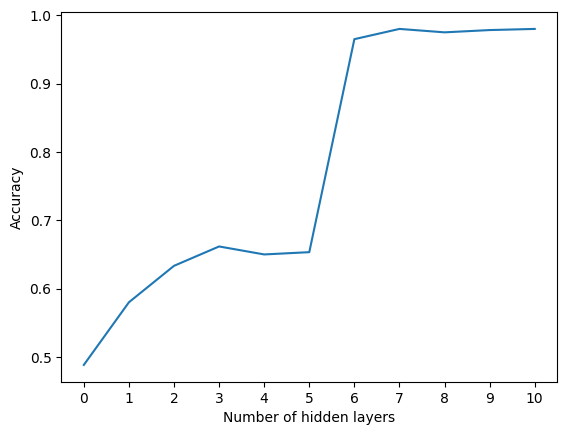

In [13]:
plt.figure()
plt.plot([i for i in range(11)], accuracy)
plt.xticks([i for i in range(11)])
plt.xlabel("Number of hidden layers"), plt.ylabel("Accuracy")
plt.show()
#TODO>

### Classification on MNIST

Load the MNIST dataset (images of size 28x28):

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
path = './' #TO ADAPT IF NEEDED
f = gzip.open(path+'mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f,encoding='bytes')
f.close()

#%% Shuffle the data and define the data variables
X_train,y_train = train_set
X_test,y_test = test_set

inds=np.arange(0,X_train.shape[0])
np.random.shuffle(inds)
X_train,y_train = X_train[inds],y_train[inds] 

inds=np.arange(0,X_test.shape[0])
np.random.shuffle(inds)
X_test,y_test = X_test[inds],y_test[inds] 

print(X_train.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)


Train the classifier on this dataset:

In [16]:
#TODO<
classifier = NN2LClassifier(nclasses=10, ndims=784)
classifier.train(X_train, y_train, learning_rate=1, reg_weight=0.001, num_iters=1000)
#TODO>

iteration 0: loss=2.306801 ; train_acc:0.336540
iteration 50: loss=0.530235 ; train_acc:0.806960
iteration 100: loss=0.378862 ; train_acc:0.893080
iteration 150: loss=0.335146 ; train_acc:0.924920
iteration 200: loss=0.264231 ; train_acc:0.940820
iteration 250: loss=0.244783 ; train_acc:0.947700
iteration 300: loss=0.234408 ; train_acc:0.950820
iteration 350: loss=0.231702 ; train_acc:0.952520
iteration 400: loss=0.214817 ; train_acc:0.958060
iteration 450: loss=0.206991 ; train_acc:0.961060
iteration 500: loss=1.051280 ; train_acc:0.672800
iteration 550: loss=0.205947 ; train_acc:0.962560
iteration 600: loss=0.196967 ; train_acc:0.965940
iteration 650: loss=0.192078 ; train_acc:0.967720
iteration 700: loss=0.192845 ; train_acc:0.967300
iteration 750: loss=0.186336 ; train_acc:0.970340
iteration 800: loss=0.183177 ; train_acc:0.971300
iteration 850: loss=0.180732 ; train_acc:0.972280
iteration 900: loss=0.183142 ; train_acc:0.970700
iteration 950: loss=0.178680 ; train_acc:0.973160


0.97426

Test the classifier on the test set:

In [17]:
#TODO<
classifier.accuracy(X_test, y_test)
#TODO>

0.9671

How do these results compare to the previous classification results on MNIST ? *--> much longer to train but gain of accuracy about 5%*